In [50]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
from scipy.signal import find_peaks
import sys
import os
import pandas as pd

In [51]:
#Function definitions

def read_theo(mol,f,fun):
    script_dir = os.getcwd()
    filename=mol+' '+f+" wide "+fun+'.txt'
#Relative path to directory with theoretical spectra e.g. 0068_closed
    rel_path='00'+mol+'_'+f+'/'
    path=os.path.join(script_dir,rel_path)
    theo_spec=genfromtxt(path+filename, delimiter='     ',dtype=float)
    return theo_spec
#Theoretical peak detection
def theo_peaks(SF,wavenumbers_theo,heights_theo):
    #D=8
    D=8
    H=0.02
    peaks_theo, _ = find_peaks(heights_theo,height=H,threshold=T,distance=D)
    return peaks_theo
#error calculation
#Calculate errors
def calculate_MAE():
    print("Error calculation:")
    #ADJUSTABLE PARAMETERS
    #tolerance for wavenumbers (when range jump is required)
    tol=40
    #tolerance for height ratio (when the exp and theoretical heights are so off that the band assignement must be wrong)
    htol=3
    error=[]
    #Sort from highest exp
    s=np.array(h_exp)
    sort_exp=s.argsort()[::-1][:len(h_exp)]
#    print("SORTED")
 #   print(sort_exp)
 #   for i in range(len(sort_exp)):
  #      print(y[sort_exp[i]],h_exp[sort_exp[i]])
        #Sort from highest theo
    s=np.array(h_theo)
    sort_theo=s.argsort()[::-1][:len(h_theo)]
#    print("SORTED")
 #   print(sort_theo)
 #   for i in range(len(sort_theo)):
  #      print(y_theo[sort_theo[i]],h_theo[sort_theo[i]])
    
    #Start from the highest experimental peak
    max_exp = max(range(len(h_exp)), key=h_exp.__getitem__)
    print("Maximum exp. peak at ",y[max_exp]," height: ",h_exp[max_exp])
    
    #Starting index for theoretical spectrum
 
    j=0
    assigned=[]
    assigned_theo_number=[]
    assigned_exp_number=[]
    to_assign=20
    index=0
# Starting index for experimental spectrum. We go right first.
    for k in range(0,to_assign):
        matching_peak=y_theo[0]
        i=sort_exp[k]
        for l in range(len(sort_theo)):
            j=sort_theo[l]
            if abs(y[i]-y_theo[j])<abs(y[i]-matching_peak) and h_exp[i]/h_theo[j]<htol and h_theo[j]/h_exp[i]<htol and j not in assigned_theo_number:
                matching_peak=y_theo[j]
                index=j
        if abs(y[i]-matching_peak)<tol:
            error.append(y[i]-matching_peak)
            assigned.append([y[i],matching_peak])
            assigned_theo_number.append(index)
            assigned_exp_number.append(i) 
# Trying to match missing peaks
    for k in range(0,to_assign):
        matching_peak=0.0
        i=sort_exp[k]
        if i not in assigned_exp_number:
            print('Warning: accepted tolerance not achieved for peak {}'.format(y[i]))
            for l in range(len(sort_theo)):
                j=sort_theo[l]
                if abs(y[i]-y_theo[j])<abs(y[i]-matching_peak) and h_exp[i]/h_theo[j]<htol and h_theo[j]/h_exp[i]<htol:
                    matching_peak=y_theo[j]
                    index=j
                    
            print("Consider these matches manually:")
            print("For experimental peak {} cm-1, height {}, best theoretical match is {} cm-1, height {}".format(y[i], h_exp[i],y_theo[index],h_theo[index]))

    print("\n {} peaks were assigned. Scaling factor of {} was used for the theoretical spectrum.\n".format(len(error),SF))

    df=pd.DataFrame(assigned,columns=["Exp. waveno.","Scaled theo. waveno."])
    df["Exp. peak height"]=[h_exp[i] for i in assigned_exp_number]
    df["Theo. peak height"]=[h_theo[i] for i in assigned_theo_number]
    df['Deviations']=df["Exp. waveno."]-df["Scaled theo. waveno."]
    display(df)

    print("\n Mean absolute error: \n")
    MAE=   sum(abs(i) for i in error)/len(error)
    print("MAE = {} cm-1".format(round(MAE,2)))
    return MAE,len(error)


In [52]:
script_dir = os.getcwd()
np.set_printoptions(precision=6,threshold=sys.maxsize)

In [53]:
#set parameters
H=0.02
#H=0.05
T=0.0
D=8
#experimental resolution
res=8.0

In [54]:
#Input data parameters
# Names of theoretical spectra files follow the convention "molecule form wide functional"
molecule='68'
form='closed'
functional=["pbe0","pbe0-d3",'b3lyp', 'b3lyp-d3', 'cam-b3lyp', 'cam-b3lyp-d3','m06l','wb97-xd', 'lc-wpbe','lc-wpbe-d3']
#scaling factors for given functionals
scaling_f={'pbe0':0.95, 'pbe0-d3':0.95, 'b3lyp': 0.959, 'b3lyp-d3': 0.959, 'cam-b3lyp': 0.951, 'cam-b3lyp-d3': 0.951,'m06l': 0.951, 'wb97-xd': 0.95, 'lc-wpbe': 0.9491,'lc-wpbe-d3' : 0.9491}


In [55]:
#Read in the experimental data for the selected molecule
#Data  in two columns without headers, separated by comma
exp_spec = genfromtxt('68 closed.dat', delimiter=',',dtype=float)
wavenumbers=exp_spec[:,0]
heights=exp_spec[:,1]/max(exp_spec[:,1])
#height - minimal height of the peak, threshold - minimal vertical distance between a peak and its neighbor, Distance - minimal distance
peaks, _ = find_peaks(heights,height=H,threshold=T,distance=D)
y=[wavenumbers[j] for j in peaks]
h_exp=[heights[j] for j in peaks]
print("Peaks detected of min. height of {}, vertical threshold {} and {}-point distance between neighbors are: ".format(H,T,D))
print(y)
no_of_peaks=len(y)
print("{} peaks fulfilling the criteria in experimental spectrum".format(no_of_peaks))

Peaks detected of min. height of 0.02, vertical threshold 0.0 and 8-point distance between neighbors are: 
[505.2833, 555.4258, 566.033, 615.2113, 624.8541, 641.2469, 678.8538, 823.496, 831.2103, 851.4601, 933.424, 968.1381, 978.7452, 986.4595, 1000.924, 1061.673, 1133.995, 1158.102, 1182.208, 1192.816, 1210.173, 1254.53, 1274.78, 1303.708, 1336.494, 1365.422, 1379.886, 1443.529, 1457.029, 1464.743, 1472.457, 1539.957, 1549.6, 1558.278, 1575.635, 1594.921, 1631.563, 1640.242, 1653.742, 1746.313, 2862.95, 2925.629, 2975.771]
43 peaks fulfilling the criteria in experimental spectrum


pbe0
Theoretical peaks detected of min. height of 0.02, vertical threshold 0.0 and 8-point distance between neighbors are: 
[496.84999999999997, 544.35, 551.9499999999999, 606.1, 628.9, 728.65, 774.25, 802.75, 833.15, 909.15, 941.4499999999999, 964.25, 981.3499999999999, 1053.55, 1079.2, 1103.8999999999999, 1130.5, 1141.8999999999999, 1165.6499999999999, 1182.75, 1206.5, 1232.1499999999999, 1290.1, 1307.2, 1331.8999999999999, 1368.95, 1384.1499999999999, 1609.3, 1642.55, 1653.0, 1660.6, 2902.25, 2910.7999999999997, 2981.1, 3015.2999999999997]


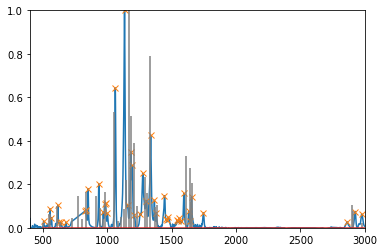

Error calculation:
Maximum exp. peak at  1133.995  height:  1.0
Consider these matches manually:
For experimental peak 1443.529 cm-1, height 0.14724178553141298, best theoretical match is 1384.1499999999999 cm-1, height 0.10644005601509851
Consider these matches manually:
For experimental peak 823.496 cm-1, height 0.07531446537080597, best theoretical match is 833.15 cm-1, height 0.16393390871328514
Consider these matches manually:
For experimental peak 968.1381 cm-1, height 0.07168142225709734, best theoretical match is 964.25 cm-1, height 0.039877524224603784
Consider these matches manually:
For experimental peak 1746.313 cm-1, height 0.06884173825263441, best theoretical match is 1660.6 cm-1, height 0.20619321858414028
Consider these matches manually:
For experimental peak 1000.924 cm-1, height 0.06715718768890352, best theoretical match is 981.3499999999999 cm-1, height 0.16692681885731914
Consider these matches manually:
For experimental peak 1210.173 cm-1, height 0.06000936110169

,Exp. waveno.,Scaled theo. waveno.,Exp. peak height,Theo. peak height,Deviations
0,1133.99,1165.65,1.00,1.00,-31.65
1,1061.67,1053.55,0.64,0.53,8.12
2,1336.49,1331.90,0.43,0.79,4.59
3,1182.21,1182.75,0.35,0.52,-0.54
4,1192.82,1206.50,0.29,0.39,-13.68
5,1274.78,1290.10,0.25,0.23,-15.32
6,933.42,941.45,0.20,0.09,-8.03
7,851.46,833.15,0.18,0.16,18.31
8,1594.92,1609.30,0.16,0.33,-14.38
9,1653.74,1653.00,0.14,0.12,0.74



 Mean absolute error: 

MAE = 11.96 cm-1
11.960356521739122 23
pbe0-d3
Theoretical peaks detected of min. height of 0.02, vertical threshold 0.0 and 8-point distance between neighbors are: 
[497.79999999999995, 545.3, 552.9, 606.1, 629.85, 729.5999999999999, 776.15, 803.6999999999999, 836.0, 912.9499999999999, 943.3499999999999, 967.0999999999999, 981.3499999999999, 1053.55, 1080.1499999999999, 1105.8, 1129.55, 1143.8, 1166.6, 1183.7, 1204.6, 1235.0, 1292.0, 1310.05, 1332.85, 1368.95, 1381.3, 1613.1, 1643.5, 1653.9499999999998, 1663.4499999999998, 2901.2999999999997, 2909.85, 2980.1499999999996, 3014.35]


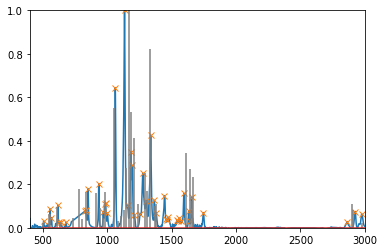

Error calculation:
Maximum exp. peak at  1133.995  height:  1.0
Consider these matches manually:
For experimental peak 1443.529 cm-1, height 0.14724178553141298, best theoretical match is 1381.3 cm-1, height 0.11120219599211187
Consider these matches manually:
For experimental peak 1631.563 cm-1, height 0.07770892529613764, best theoretical match is 1653.9499999999998 cm-1, height 0.12139191807249894
Consider these matches manually:
For experimental peak 823.496 cm-1, height 0.07531446537080597, best theoretical match is 836.0 cm-1, height 0.1664044518447849
Consider these matches manually:
For experimental peak 968.1381 cm-1, height 0.07168142225709734, best theoretical match is 967.0999999999999 cm-1, height 0.044038102381770985
Consider these matches manually:
For experimental peak 1746.313 cm-1, height 0.06884173825263441, best theoretical match is 1653.9499999999998 cm-1, height 0.12139191807249894
Consider these matches manually:
For experimental peak 1000.924 cm-1, height 0.0671

,Exp. waveno.,Scaled theo. waveno.,Exp. peak height,Theo. peak height,Deviations
0,1133.99,1166.60,1.00,1.00,-32.61
1,1061.67,1053.55,0.64,0.55,8.12
2,1336.49,1332.85,0.43,0.82,3.64
3,1182.21,1183.70,0.35,0.53,-1.49
4,1192.82,1204.60,0.29,0.41,-11.78
5,1274.78,1292.00,0.25,0.25,-17.22
6,933.42,943.35,0.20,0.09,-9.93
7,851.46,836.00,0.18,0.17,15.46
8,1594.92,1613.10,0.16,0.34,-18.18
9,1653.74,1653.95,0.14,0.12,-0.21



 Mean absolute error: 

MAE = 10.9 cm-1
10.900781818181786 22
b3lyp
Theoretical peaks detected of min. height of 0.02, vertical threshold 0.0 and 8-point distance between neighbors are: 
[421.001, 497.721, 540.876, 549.507, 580.1949999999999, 600.334, 610.8829999999999, 658.833, 724.045, 767.1999999999999, 780.626, 800.765, 824.74, 909.132, 940.779, 953.246, 971.467, 1005.0319999999999, 1043.392, 1068.326, 1085.588, 1101.8909999999998, 1126.825, 1141.21, 1163.267, 1179.57, 1223.684, 1271.634, 1306.158, 1328.215, 1338.764, 1384.796, 1398.222, 1590.022, 1629.341, 1646.6029999999998, 2902.893, 2921.114, 2968.105, 3005.506, 3057.292]


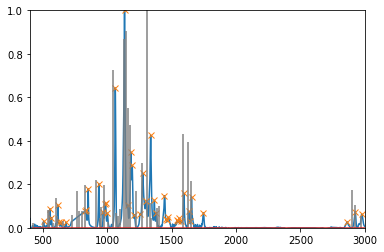

Error calculation:
Maximum exp. peak at  1133.995  height:  1.0
Consider these matches manually:
For experimental peak 1443.529 cm-1, height 0.14724178553141298, best theoretical match is 1398.222 cm-1, height 0.10142846966807903
Consider these matches manually:
For experimental peak 1158.102 cm-1, height 0.10305127795051164, best theoretical match is 1101.8909999999998 cm-1, height 0.08435596904411771
Consider these matches manually:
For experimental peak 1631.563 cm-1, height 0.07770892529613764, best theoretical match is 1646.6029999999998 cm-1, height 0.2147819460691271
Consider these matches manually:
For experimental peak 823.496 cm-1, height 0.07531446537080597, best theoretical match is 824.74 cm-1, height 0.19710435656054698
Consider these matches manually:
For experimental peak 1746.313 cm-1, height 0.06884173825263441, best theoretical match is 1398.222 cm-1, height 0.10142846966807903
Consider these matches manually:
For experimental peak 1000.924 cm-1, height 0.06715718768

,Exp. waveno.,Scaled theo. waveno.,Exp. peak height,Theo. peak height,Deviations
0,1133.99,1126.83,1.00,0.87,7.17
1,1061.67,1043.39,0.64,0.73,18.28
2,1336.49,1306.16,0.43,1.00,30.34
3,1182.21,1179.57,0.35,0.48,2.64
4,1192.82,1163.27,0.29,0.55,29.55
5,1274.78,1271.63,0.25,0.30,3.15
6,933.42,953.25,0.20,0.09,-19.82
7,851.46,824.74,0.18,0.20,26.72
8,1594.92,1590.02,0.16,0.43,4.90
9,1653.74,1646.60,0.14,0.21,7.14



 Mean absolute error: 

MAE = 17.52 cm-1
17.522231818181822 22
b3lyp-d3
Theoretical peaks detected of min. height of 0.02, vertical threshold 0.0 and 8-point distance between neighbors are: 
[423.878, 498.68, 540.876, 551.425, 584.031, 601.293, 612.8009999999999, 662.669, 725.963, 769.1179999999999, 781.5849999999999, 802.683, 831.453, 914.886, 946.533, 956.1229999999999, 973.385, 1005.991, 1045.31, 1071.203, 1089.424, 1099.973, 1127.7839999999999, 1144.087, 1166.144, 1176.693, 1226.561, 1245.741, 1273.552, 1309.0349999999999, 1333.01, 1384.796, 1398.222, 1596.735, 1632.2179999999998, 1643.7259999999999, 1651.398, 2900.016, 2918.237, 2967.1459999999997, 3005.506, 3058.2509999999997]


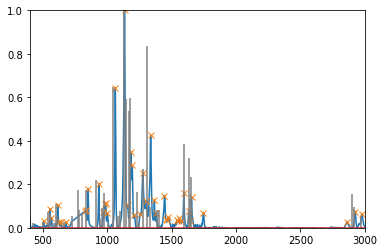

Error calculation:
Maximum exp. peak at  1133.995  height:  1.0
Consider these matches manually:
For experimental peak 1443.529 cm-1, height 0.14724178553141298, best theoretical match is 1398.222 cm-1, height 0.08160612602715495
Consider these matches manually:
For experimental peak 1158.102 cm-1, height 0.10305127795051164, best theoretical match is 1099.973 cm-1, height 0.07730334964334462
Consider these matches manually:
For experimental peak 823.496 cm-1, height 0.07531446537080597, best theoretical match is 831.453 cm-1, height 0.17157732121941402
Consider these matches manually:
For experimental peak 1746.313 cm-1, height 0.06884173825263441, best theoretical match is 1643.7259999999999 cm-1, height 0.13373930092096428
Consider these matches manually:
For experimental peak 1000.924 cm-1, height 0.06715718768890352, best theoretical match is 973.385 cm-1, height 0.1595483408336085
Consider these matches manually:
For experimental peak 1472.457 cm-1, height 0.04783541118012186, be

,Exp. waveno.,Scaled theo. waveno.,Exp. peak height,Theo. peak height,Deviations
0,1133.99,1127.78,1.00,1.00,6.21
1,1061.67,1045.31,0.64,0.65,16.36
2,1336.49,1309.03,0.43,0.83,27.46
3,1182.21,1176.69,0.35,0.60,5.52
4,1192.82,1166.14,0.29,0.54,26.67
5,1274.78,1273.55,0.25,0.27,1.23
6,933.42,914.89,0.20,0.22,18.54
7,851.46,831.45,0.18,0.17,20.01
8,1594.92,1596.73,0.16,0.39,-1.81
9,1653.74,1651.40,0.14,0.23,2.34



 Mean absolute error: 

MAE = 14.12 cm-1
14.115012500000015 24
cam-b3lyp
Theoretical peaks detected of min. height of 0.02, vertical threshold 0.0 and 8-point distance between neighbors are: 
[501.17699999999996, 545.874, 556.3349999999999, 607.689, 619.101, 732.27, 776.967, 791.232, 809.3009999999999, 835.929, 917.7149999999999, 950.049, 971.9219999999999, 989.04, 1009.011, 1059.414, 1086.042, 1114.572, 1146.906, 1172.5829999999999, 1188.75, 1211.5739999999998, 1243.908, 1303.821, 1340.9099999999999, 1381.8029999999999, 1394.166, 1635.72, 1661.397, 1670.907, 1685.172, 2907.207, 2918.6189999999997, 2978.5319999999997, 3009.915]


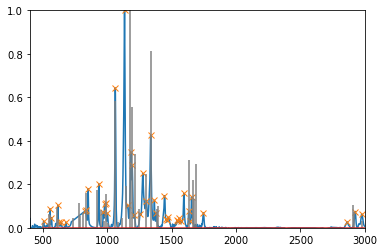

Error calculation:
Maximum exp. peak at  1133.995  height:  1.0
Consider these matches manually:
For experimental peak 1594.921 cm-1, height 0.15788055792745698, best theoretical match is 1635.72 cm-1, height 0.3134204851376321
Consider these matches manually:
For experimental peak 1443.529 cm-1, height 0.14724178553141298, best theoretical match is 1394.166 cm-1, height 0.09939380363360191
Consider these matches manually:
For experimental peak 1303.708 cm-1, height 0.12507453090964632, best theoretical match is 1303.821 cm-1, height 0.24765795356155734
Consider these matches manually:
For experimental peak 1746.313 cm-1, height 0.06884173825263441, best theoretical match is 1670.907 cm-1, height 0.13391704726048176
Consider these matches manually:
For experimental peak 1210.173 cm-1, height 0.06000936110169644, best theoretical match is 1243.908 cm-1, height 0.08743989407092043
Consider these matches manually:
For experimental peak 1472.457 cm-1, height 0.04783541118012186, best theor

,Exp. waveno.,Scaled theo. waveno.,Exp. peak height,Theo. peak height,Deviations
0,1133.99,1172.58,1.00,1.00,-38.59
1,1061.67,1059.41,0.64,0.58,2.26
2,1336.49,1340.91,0.43,0.81,-4.42
3,1182.21,1188.75,0.35,0.56,-6.54
4,1192.82,1211.57,0.29,0.34,-18.76
5,1274.78,1303.82,0.25,0.25,-29.04
6,933.42,917.71,0.20,0.17,15.71
7,851.46,835.93,0.18,0.16,15.53
8,1653.74,1661.40,0.14,0.22,-7.65
9,1365.42,1381.80,0.13,0.09,-16.38



 Mean absolute error: 

MAE = 14.41 cm-1
14.41022916666663 24
cam-b3lyp-d3
Theoretical peaks detected of min. height of 0.02, vertical threshold 0.0 and 8-point distance between neighbors are: 
[501.17699999999996, 545.874, 558.237, 608.64, 620.052, 627.66, 733.221, 777.918, 793.134, 810.252, 839.733, 922.4699999999999, 952.9019999999999, 974.775, 989.991, 1009.011, 1061.316, 1086.993, 1117.425, 1138.347, 1149.759, 1173.5339999999999, 1191.6029999999998, 1210.623, 1246.761, 1305.723, 1341.8609999999999, 1381.8029999999999, 1395.117, 1639.524, 1663.299, 1673.76, 1688.9759999999999, 2905.305, 2917.6679999999997, 2978.5319999999997, 3008.964]


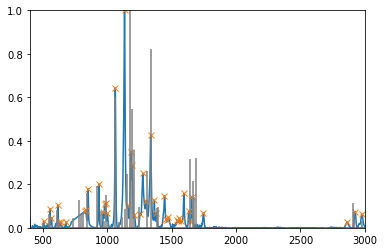

Error calculation:
Maximum exp. peak at  1133.995  height:  1.0
Consider these matches manually:
For experimental peak 1594.921 cm-1, height 0.15788055792745698, best theoretical match is 1639.524 cm-1, height 0.31715946464287587
Consider these matches manually:
For experimental peak 1443.529 cm-1, height 0.14724178553141298, best theoretical match is 1395.117 cm-1, height 0.09569813364169996
Consider these matches manually:
For experimental peak 1631.563 cm-1, height 0.07770892529613764, best theoretical match is 1663.299 cm-1, height 0.21348766112866355
Consider these matches manually:
For experimental peak 1746.313 cm-1, height 0.06884173825263441, best theoretical match is 1673.76 cm-1, height 0.14081868430234487
Consider these matches manually:
For experimental peak 1254.53 cm-1, height 0.06569094746521749, best theoretical match is 1246.761 cm-1, height 0.09546103232581489
Consider these matches manually:
For experimental peak 1210.173 cm-1, height 0.06000936110169644, best theor

,Exp. waveno.,Scaled theo. waveno.,Exp. peak height,Theo. peak height,Deviations
0,1133.99,1173.53,1.00,1.00,-39.54
1,1061.67,1061.32,0.64,0.60,0.36
2,1336.49,1341.86,0.43,0.82,-5.37
3,1182.21,1191.60,0.35,0.55,-9.39
4,1192.82,1210.62,0.29,0.36,-17.81
5,1274.78,1246.76,0.25,0.10,28.02
6,933.42,922.47,0.20,0.19,10.95
7,851.46,839.73,0.18,0.16,11.73
8,1653.74,1663.30,0.14,0.21,-9.56
9,1365.42,1381.80,0.13,0.09,-16.38



 Mean absolute error: 

MAE = 12.54 cm-1
12.542821739130401 23
m06l
Theoretical peaks detected of min. height of 0.02, vertical threshold 0.0 and 8-point distance between neighbors are: 
[421.293, 493.56899999999996, 536.3639999999999, 546.8249999999999, 598.179, 621.0029999999999, 656.1899999999999, 720.858, 756.045, 767.457, 795.036, 822.615, 900.597, 933.882, 970.971, 988.0889999999999, 1042.296, 1080.336, 1098.405, 1115.523, 1138.347, 1150.71, 1164.024, 1226.79, 1274.34, 1296.213, 1305.723, 1318.086, 1360.8809999999999, 1375.146, 1596.7289999999998, 1635.72, 1652.838, 2897.6969999999997, 2988.042, 3018.4739999999997, 3026.082, 3034.641]


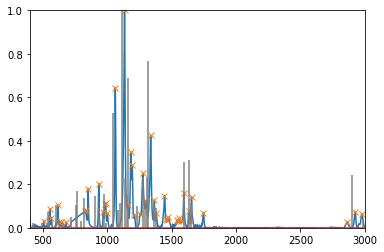

Error calculation:
Maximum exp. peak at  1133.995  height:  1.0
Consider these matches manually:
For experimental peak 1443.529 cm-1, height 0.14724178553141298, best theoretical match is 1375.146 cm-1, height 0.09151668815831851
Consider these matches manually:
For experimental peak 978.7452 cm-1, height 0.10842246888610563, best theoretical match is 970.971 cm-1, height 0.15549680491370585
Consider these matches manually:
For experimental peak 1631.563 cm-1, height 0.07770892529613764, best theoretical match is 1652.838 cm-1, height 0.11373285957631424
Consider these matches manually:
For experimental peak 823.496 cm-1, height 0.07531446537080597, best theoretical match is 822.615 cm-1, height 0.13589435505279804
Consider these matches manually:
For experimental peak 2925.629 cm-1, height 0.07494305524087874, best theoretical match is 2988.042 cm-1, height 0.027806573159838237
Consider these matches manually:
For experimental peak 968.1381 cm-1, height 0.07168142225709734, best theor

,Exp. waveno.,Scaled theo. waveno.,Exp. peak height,Theo. peak height,Deviations
0,1133.99,1115.52,1.00,1.00,18.47
1,1061.67,1042.30,0.64,0.53,19.38
2,1336.49,1318.09,0.43,0.77,18.41
3,1182.21,1164.02,0.35,0.69,18.18
4,1192.82,1226.79,0.29,0.10,-33.97
5,1274.78,1274.34,0.25,0.23,0.44
6,933.42,933.88,0.20,0.09,-0.46
7,851.46,822.62,0.18,0.14,28.85
8,1594.92,1596.73,0.16,0.30,-1.81
9,1653.74,1652.84,0.14,0.11,0.90



 Mean absolute error: 

MAE = 12.52 cm-1
12.520231578947346 19
wb97-xd
Theoretical peaks detected of min. height of 0.02, vertical threshold 0.0 and 8-point distance between neighbors are: 
[498.75, 546.25, 554.8, 606.1, 617.5, 626.05, 730.55, 773.3, 782.8, 804.65, 836.0, 916.75, 946.1999999999999, 957.5999999999999, 970.9, 982.3, 1005.0999999999999, 1052.6, 1082.05, 1109.6, 1129.55, 1142.85, 1165.6499999999999, 1184.6499999999999, 1201.75, 1237.85, 1292.0, 1331.8999999999999, 1380.35, 1394.6, 1634.0, 1658.6999999999998, 1668.1999999999998, 1680.55, 2905.1, 2913.65, 2988.7, 3014.35]


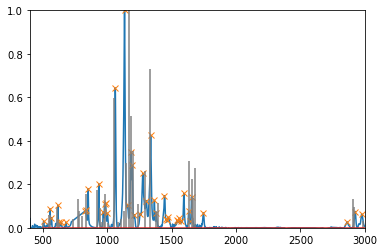

Error calculation:
Maximum exp. peak at  1133.995  height:  1.0
Consider these matches manually:
For experimental peak 1443.529 cm-1, height 0.14724178553141298, best theoretical match is 1394.6 cm-1, height 0.11551565654059902
Consider these matches manually:
For experimental peak 1303.708 cm-1, height 0.12507453090964632, best theoretical match is 1292.0 cm-1, height 0.2597872342240912
Consider these matches manually:
For experimental peak 823.496 cm-1, height 0.07531446537080597, best theoretical match is 836.0 cm-1, height 0.15756454683712764
Consider these matches manually:
For experimental peak 1746.313 cm-1, height 0.06884173825263441, best theoretical match is 1668.1999999999998 cm-1, height 0.13594674915553584
Consider these matches manually:
For experimental peak 1000.924 cm-1, height 0.06715718768890352, best theoretical match is 982.3 cm-1, height 0.15488515610373235
Consider these matches manually:
For experimental peak 1210.173 cm-1, height 0.06000936110169644, best theor

,Exp. waveno.,Scaled theo. waveno.,Exp. peak height,Theo. peak height,Deviations
0,1133.99,1165.65,1.00,1.00,-31.65
1,1061.67,1052.60,0.64,0.60,9.07
2,1336.49,1331.90,0.43,0.73,4.59
3,1182.21,1184.65,0.35,0.51,-2.44
4,1192.82,1201.75,0.29,0.35,-8.93
5,1274.78,1292.00,0.25,0.26,-17.22
6,933.42,946.20,0.20,0.09,-12.78
7,851.46,836.00,0.18,0.16,15.46
8,1594.92,1634.00,0.16,0.31,-39.08
9,1653.74,1658.70,0.14,0.23,-4.96



 Mean absolute error: 

MAE = 14.27 cm-1
14.267404347826048 23
lc-wpbe
Theoretical peaks detected of min. height of 0.02, vertical threshold 0.0 and 8-point distance between neighbors are: 
[503.023, 548.5798, 559.0199, 591.2893, 611.2204, 626.4060000000001, 653.9299000000001, 737.4507000000001, 783.0075, 801.0404000000001, 817.1751, 847.5463000000001, 921.5761, 956.6928, 981.3694, 1002.2496000000001, 1047.8064000000002, 1069.6357, 1099.0578, 1146.5128, 1163.5966, 1194.9169000000002, 1204.4079000000002, 1228.1354000000001, 1264.2012, 1286.9796000000001, 1321.1472, 1330.6382, 1339.1801, 1351.5184000000002, 1365.7549000000001, 1379.0423, 1388.5333, 1678.0088, 1693.1944, 1705.5327000000002, 1722.6165, 2939.3627, 3031.4254, 3045.6619, 3056.1020000000003]


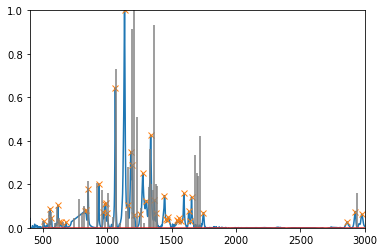

Error calculation:
Maximum exp. peak at  1133.995  height:  1.0
Consider these matches manually:
For experimental peak 1133.995 cm-1, height 1.0, best theoretical match is 1194.9169000000002 cm-1, height 0.915307763504614
Consider these matches manually:
For experimental peak 1594.921 cm-1, height 0.15788055792745698, best theoretical match is 1678.0088 cm-1, height 0.3326385819190945
Consider these matches manually:
For experimental peak 1443.529 cm-1, height 0.14724178553141298, best theoretical match is 1388.5333 cm-1, height 0.19090839702899545
Consider these matches manually:
For experimental peak 1631.563 cm-1, height 0.07770892529613764, best theoretical match is 1388.5333 cm-1, height 0.19090839702899545
Consider these matches manually:
For experimental peak 1746.313 cm-1, height 0.06884173825263441, best theoretical match is 1388.5333 cm-1, height 0.19090839702899545
Consider these matches manually:
For experimental peak 1000.924 cm-1, height 0.06715718768890352, best theoreti

,Exp. waveno.,Scaled theo. waveno.,Exp. peak height,Theo. peak height,Deviations
0,1061.67,1069.64,0.64,0.73,-7.96
1,1336.49,1339.18,0.43,0.20,-2.69
2,1182.21,1194.92,0.35,0.92,-12.71
3,1192.82,1163.60,0.29,0.28,29.22
4,1274.78,1264.20,0.25,0.09,10.58
5,933.42,921.58,0.20,0.20,11.85
6,851.46,847.55,0.18,0.22,3.91
7,1653.74,1678.01,0.14,0.33,-24.27
8,1365.42,1379.04,0.13,0.20,-13.62
9,1303.71,1321.15,0.13,0.19,-17.44



 Mean absolute error: 

MAE = 14.57 cm-1
14.571119047619081 21
lc-wpbe-d3
Theoretical peaks detected of min. height of 0.02, vertical threshold 0.0 and 8-point distance between neighbors are: 
[430.89140000000003, 503.9721, 549.5289, 559.969, 595.0857000000001, 611.2204, 627.3551, 654.879, 739.3489000000001, 785.8548000000001, 801.9895, 818.1242000000001, 852.2918000000001, 927.2707, 959.5401, 985.1658000000001, 1004.1478000000001, 1050.6537, 1070.5848, 1100.0069, 1148.411, 1166.4439, 1195.866, 1205.357, 1227.1863, 1267.0485, 1290.776, 1323.9945, 1332.5364000000002, 1340.1292, 1352.4675, 1366.7040000000002, 1379.0423, 1389.4824, 1681.8052, 1695.0926000000002, 1707.4309, 1726.4129, 2937.4645, 3030.4763000000003, 3045.6619, 3055.1529]


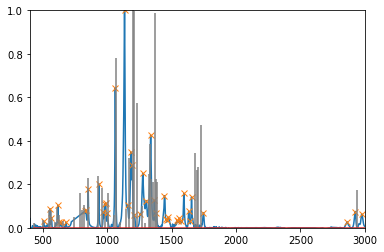

Error calculation:
Maximum exp. peak at  1133.995  height:  1.0
Consider these matches manually:
For experimental peak 1133.995 cm-1, height 1.0, best theoretical match is 1195.866 cm-1, height 1.0
Consider these matches manually:
For experimental peak 1594.921 cm-1, height 0.15788055792745698, best theoretical match is 1681.8052 cm-1, height 0.3420573868567059
Consider these matches manually:
For experimental peak 1443.529 cm-1, height 0.14724178553141298, best theoretical match is 1389.4824 cm-1, height 0.20990549355093602
Consider these matches manually:
For experimental peak 1631.563 cm-1, height 0.07770892529613764, best theoretical match is 1389.4824 cm-1, height 0.20990549355093602
Consider these matches manually:
For experimental peak 1746.313 cm-1, height 0.06884173825263441, best theoretical match is 1290.776 cm-1, height 0.024016094084834686
Consider these matches manually:
For experimental peak 1000.924 cm-1, height 0.06715718768890352, best theoretical match is 1004.147800

,Exp. waveno.,Scaled theo. waveno.,Exp. peak height,Theo. peak height,Deviations
0,1061.67,1070.58,0.64,0.78,-8.91
1,1336.49,1340.13,0.43,0.23,-3.64
2,1182.21,1195.87,0.35,1.00,-13.66
3,1192.82,1166.44,0.29,0.32,26.37
4,1274.78,1267.05,0.25,0.10,7.73
5,933.42,927.27,0.20,0.24,6.15
6,851.46,852.29,0.18,0.23,-0.83
7,1653.74,1681.81,0.14,0.34,-28.06
8,1365.42,1352.47,0.13,0.21,12.95
9,1303.71,1323.99,0.13,0.25,-20.29



 Mean absolute error: 

MAE = 14.08 cm-1
14.07628095238097 21
Calculated MAEs for each functional:


,MAE,No. of assigned peaks
pbe0,11.96,23
pbe0-d3,10.90,22
b3lyp,17.52,22
b3lyp-d3,14.12,24
cam-b3lyp,14.41,24
cam-b3lyp-d3,12.54,23
m06l,12.52,19
wb97-xd,14.27,23
lc-wpbe,14.57,21
lc-wpbe-d3,14.08,21


In [56]:
#For selected functionals read the spectra and calculate the MAEs
MAEs={}
peaks_assigned={}
for funs in functional:
    print(funs)
    theo_spec=read_theo(molecule,form,funs) 
    SF=scaling_f[funs]
    
    wavenumbers_theo=SF*theo_spec[:,0]
    heights_theo=theo_spec[:,1]/max(theo_spec[:,1])
    
    peaks_theo=theo_peaks(SF,wavenumbers_theo,heights_theo)
    
    y_theo=[wavenumbers_theo[j] for j in peaks_theo]
    print("Theoretical peaks detected of min. height of {}, vertical threshold {} and {}-point distance between neighbors are: ".format(H,T,D))
    print(y_theo)
    h_theo=[heights_theo[j] for j in peaks_theo]
    #print(h_theo)
    no_of_peaks=len(y_theo)
    
    #draw the spectra comparison
    plt.plot(wavenumbers,heights)
    plt.ylim(ymin=0,ymax=1)
    plt.xlim(xmin=400,xmax=4000)
    plt.plot(y,heights[peaks],"x")
#fig, ax = plt.subplots()
    plt.stem(y_theo, heights_theo[peaks_theo],markerfmt=' ',linefmt='grey')
#plt.stem(y_theo,heights[peaks_theo] ,markerfmt=' ',linefmt='grey')
    plt.ylim(ymin=0,ymax=1)
    plt.xlim(xmin=400,xmax=3000)
    plt.show()
    m,n=calculate_MAE()
    MAEs[funs]=m
    peaks_assigned[funs]=n
    print(m,n)
    
pd.set_option('display.precision', 2)
print("Calculated MAEs for each functional:")
df=pd.DataFrame.from_dict(MAEs,orient='index',columns=['MAE'])
df['No. of assigned peaks']=peaks_assigned.values()

display(df)

    